<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/backtestBacktrading/blob/main/daytrader6mesindicadoresegrafico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yahoo_fin


     |████████████████████████████████| 81 kB 6.7 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
     |████████████████████████████████| 103 kB 47.4 MB/s 
     |████████████████████████████████| 127 kB 43.2 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=1da5bee23bf6e2097ccbe8ed4fd45333d3ce0cb439cbdec704d6628348922614
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=5ae75e2d9e8eec3c006f9da145679819194c7c0cf2878c3b2712698faa09f4ee
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=ecd6b1442eade3e6c885fdf2a1a2c11c69444b7a9b9209c26b978ce476cc2b69
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36ce

In [2]:
#instala biblioteca yfinance
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 12.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=44c05cba57e051430be3d07918531e90153568b8ec8649ee2249237071062ecd
  Stored in directory: /tmp/pip-ephem-wheel-cache-hcx66zs0/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
#instala request
!pip install requests_html

In [4]:
# Instalar Backtrader
!pip install backtrader

     |████████████████████████████████| 410 kB 7.6 MB/s 


In [5]:
!pip install backtrader[plotting]


In [6]:
# Obtenha os pacotes necessários

import datetime  
import backtrader as bt
from IPython.display import display, Image
import yfinance as yf
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import os
import sys
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])


In [27]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [28]:
from yahoo_fin.stock_info import get_data
data = get_data("BTC-USD", start_date="05/10/2021", end_date="11/10/2021", index_as_date = True, interval="1d")
data

,open,high,low,close,adjclose,volume,ticker
2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,71776546298,BTC-USD
2021-05-11,55847.242188,56872.542969,54608.652344,56704.574219,56704.574219,61308396325,BTC-USD
2021-05-12,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,75215403907,BTC-USD
2021-05-13,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,96721152926,BTC-USD
2021-05-14,49682.980469,51438.117188,48868.578125,49880.535156,49880.535156,55737497453,BTC-USD
...,...,...,...,...,...,...,...
2021-11-06,61068.875000,61590.683594,60163.781250,61527.480469,61527.480469,29094934221,BTC-USD
2021-11-07,61554.921875,63326.988281,61432.488281,63326.988281,63326.988281,24726754302,BTC-USD
2021-11-08,63344.066406,67673.742188,63344.066406,67566.828125,67566.828125,41125608330,BTC-USD
2021-11-09,67549.734375,68530.335938,66382.062500,66971.828125,66971.828125,42357991721,BTC-USD


In [29]:
data.to_csv('/content/cripto.csv')

In [30]:
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, csv, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), csv))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [31]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

In [32]:
# Add a strategy
cerebro.addstrategy(TestStrategy)

0

In [13]:
# Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
datapath = os.path.join(modpath, '/content/cripto.csv')

In [34]:
# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
              reverse=False)

In [35]:
# Add the Data Feed to Cerebro
cerebro.adddata(data)

In [36]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00


In [38]:
 # Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)


In [39]:
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.1)

In [40]:
# Rodando cerebro
cerebro.run()

2021-06-12, Close, 35552.52
2021-06-13, Close, 39097.86
2021-06-13, BUY CREATE, 39097.86
2021-06-14, Order Canceled/Margin/Rejected
2021-06-14, Close, 40218.48
2021-06-14, BUY CREATE, 40218.48
2021-06-15, Order Canceled/Margin/Rejected
2021-06-15, Close, 40406.27
2021-06-15, BUY CREATE, 40406.27
2021-06-16, Order Canceled/Margin/Rejected
2021-06-16, Close, 38347.06
2021-06-16, BUY CREATE, 38347.06
2021-06-17, Order Canceled/Margin/Rejected
2021-06-17, Close, 38053.50
2021-06-17, BUY CREATE, 38053.50
2021-06-18, Order Canceled/Margin/Rejected
2021-06-18, Close, 35787.25
2021-06-19, Close, 35615.87
2021-06-20, Close, 35698.30
2021-06-21, Close, 31676.69
2021-06-22, Close, 32505.66
2021-06-23, Close, 33723.03
2021-06-24, Close, 34662.44
2021-06-25, Close, 31637.78
2021-06-26, Close, 32186.28
2021-06-27, Close, 34649.64
2021-06-28, Close, 34434.34
2021-06-29, Close, 35867.78
2021-06-29, BUY CREATE, 35867.78
2021-06-30, Order Canceled/Margin/Rejected
2021-06-30, Close, 35040.84
2021-06-30, 

In [41]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 100000.00


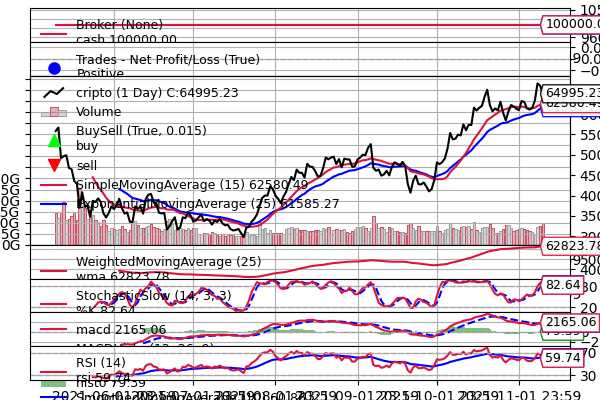

In [45]:
cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))